# Proof of concept notebook

This notebook tests out different strategies to transform images into knitting patterns, given a desired number of colours and number of stitches (across = wide)

The plan:

Testing two approaches:

- k-means
- style transfer

Testing (for k-means):

- rgb
- perceptually uniform color spaces
- cyclic colour spaces

## First approach: k-means

In [141]:
### test images: swarm1.jpeg, swarm2.jpg, swarm3.jpeg, swarm4.png, toss1.png, toss2.png
# Note that k-means on rgb works well for swarm1.jpeg, and very badly for toss1.png and toss2.png
filename = 'toss2.png'

# location of image
im_path = 'data/' + filename

# Knit stitches are wider than they are taller (1.25 wide = 1 tall)
ratio = 1.25

# Kitting size (determined by # of columns per image)
stitches = 30

# Number of yarn colours
colours = 5

In [142]:
# Loading image
import skimage
import matplotlib.pyplot as plt
from skimage import io

Shape: (1047, 860, 4)
Values min/max 0 255
after: (1047, 860, 3)


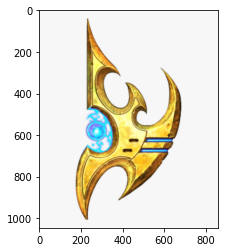

In [143]:
# Examine image
image = io.imread(im_path)
print(f'Shape: {image.shape}')
print("Values min/max", image.min(), image.max())
plt.imshow(image)


# convert from rgb-a to rgb (remove 4th element of colour) if necessary:
if image.shape[2]==4:
    image_rgb = image[:,:,:3]
    print('after:', image_rgb.shape)
else:
    image_rgb = image

(1309, 860, 3)


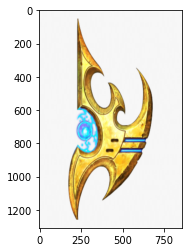

In [144]:
# Resize image

from skimage.transform import resize

h = round(image_rgb.shape[0]*ratio)
w = image_rgb.shape[1]

image_resized = resize(image_rgb, (h, w),
                       anti_aliasing=True)
plt.imshow(image_resized)
print(image_resized.shape)

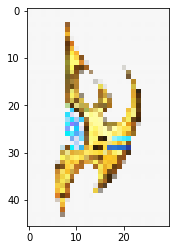

In [145]:
# Pixelate image
# Resize allows us to specify the output image shape (instead of a scaling factor)

from skimage.transform import resize

# the new height, width
h_2 = image_resized.shape[0]
w_2 = image_resized.shape[1]

# Calculate resizing factor using stiches (# desired stitches across image)
r_factor = stitches/w_2

# Rescale:
im_rescaled = resize(image_resized, (round(h_2*r_factor),round(w_2*r_factor)), anti_aliasing = False)

plt.imshow(im_rescaled)

In [146]:
# Want to make a pattern that uses k colours (e.g. k colours of yarn)

im_rescaled.shape

(46, 30, 3)

(46, 30, 3)
CPU times: user 27 µs, sys: 0 ns, total: 27 µs
Wall time: 5.96 µs


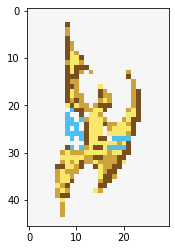

In [147]:
# Cluster the pixels using k-means (using original rgb)
from sklearn.cluster import KMeans
import numpy as np

X = im_rescaled.reshape(-1,3)

kmeans = KMeans(n_clusters = colours).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(im_rescaled.shape)
print(segmented_img.shape)

%time 

plt.imshow(segmented_img)

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 3.81 µs


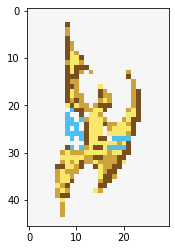

In [148]:
# Cluster the pixel colours using k-means mini batch

from sklearn.cluster import MiniBatchKMeans

X_m = im_rescaled.reshape(-1,3)

mb_kmeans = MiniBatchKMeans(n_clusters = colours).fit(X_m)
segmented_img_m = mb_kmeans.cluster_centers_[mb_kmeans.labels_]
segmented_img_m = segmented_img.reshape(im_rescaled.shape)

%time 

plt.imshow(segmented_img_m)


### Checking k-means (& k-means w/mini batch) in a different colour space

k-means (& variations) worked well with the zerg images (swarmn.format), but worked very badly for toss1.png

To resolve this issue, check some different colourspaces

before: (1047, 860, 4)
after: (1047, 860, 3)
[0.         0.         0.96862745]


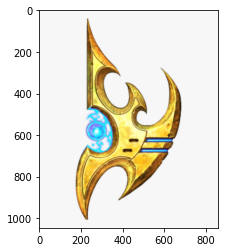

In [149]:
# Looking for a good perceptually uniform colourspace to perform clustering
from skimage.color import rgb2hsv, hsv2rgb

print('before:', image.shape)

plt.imshow(image)

# convert from rgb-a to rgb (remove 4th element of colour) if necessary:
if image.shape[2]==4:
    image_rgb = image[:,:,:3]
    print('after:', image_rgb.shape)
else:
    image_rgb = image

hsv_img = rgb2hsv(image_rgb)
print(hsv_img[0][0])


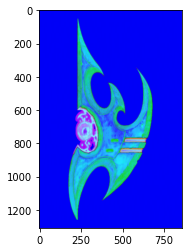

In [150]:
# Now run the same k-means (& k-means w/mini batch as above)
# (cluster in hsv, then convert back to rgb)

from skimage.transform import resize

h = round(hsv_img.shape[0]*ratio)
w = hsv_img.shape[1]

image_resized = resize(hsv_img, (h, w),
                       anti_aliasing=True)
plt.imshow(image_resized)

# Pixelate image
# Resize allows us to specify the output image shape (instead of a scaling factor)

from skimage.transform import resize

# the new height, width
h_2 = image_resized.shape[0]
w_2 = image_resized.shape[1]

# Calculate resizing factor using stiches (# desired stitches across image)
r_factor = stitches/w_2

# Rescale:
im_rescaled = resize(image_resized, (round(h_2*r_factor),round(w_2*r_factor)), anti_aliasing = False)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


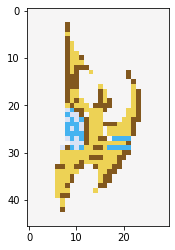

In [151]:
# Cluster the pixels using k-means (using original rgb)

X = im_rescaled.reshape(-1,3)

kmeans_h = KMeans(n_clusters = colours).fit(X)
segmented_img = kmeans_h.cluster_centers_[kmeans_h.labels_]
segmented_img = segmented_img.reshape(im_rescaled.shape)

%time 
segmented_img_r = hsv2rgb(segmented_img)

plt.imshow(segmented_img_r)

CPU times: user 15 µs, sys: 1 µs, total: 16 µs
Wall time: 5.96 µs


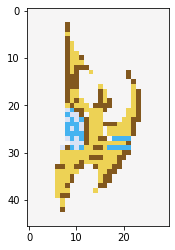

In [152]:
# Same for MiniBatch

X_m = im_rescaled.reshape(-1,3)

mb_kmeans_hsv = MiniBatchKMeans(n_clusters = colours).fit(X_m)
segmented_img_m = mb_kmeans_hsv.cluster_centers_[mb_kmeans_hsv.labels_]
segmented_img_m = segmented_img.reshape(im_rescaled.shape)

%time 

segmented_img_r_m = hsv2rgb(segmented_img_m)

plt.imshow(segmented_img_r_m)

Note that direct clustering on rgb works marginally better for swarm1 image, but clustering on hsv works much, much better for toss1 and toss2

# Future ideas
## Second approach: Style transfer

Something a bit fancy has to be done here to generate an image that has the right amount of colours and stitches. A naive approach is to autogenerate images that have roughly the correct parameters, and use these to feed into NN. Maybe a fancy loss function will give a good result (penalizing non-grid images)